In [ ]:
# Done on EffNet over predef function with features off 10 epoch

In [ ]:
#before running this please change the RUNTIME to GPU (Runtime -> Change runtime type -> set harware accelarotor as GPU)
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3824, done.
remote: Counting objects: 100% (467/467), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 3824 (delta 245), reused 402 (delta 199), pack-reused 3357
Receiving objects: 100% (3824/3824), 650.71 MiB | 15.48 MiB/s, done.
Resolving deltas: 100% (2201/2201), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#Note : only needed when you have to download the processed data to the environment
#download and unzip the data from google drive Colab environment
from google_drive_downloader import GoogleDriveDownloader as gdd

# https://drive.google.com/drive/folders/1hlagmkHvVahBBb_EJv8vhUOsZWoPYgS6?usp=share_link --------Faceforensics
# https://drive.google.com/drive/folders/1h36Be3S1Mt4tkItIHakNAReUOnLoGXOi?usp=drive_link  ------- whole data drive
#use only file id of the link
#Note: Below link is just an example, Not an actual link. Actual Links are in ReadMe file
#https://drive.google.com/file/d/1ubvKLzBDe5i1acxgGUK6ObeNBYCKUS07/view?usp=sharing
# url = '1ubvKLzBDe5i1acxgGUK6ObeNBYCKUS07'   #Like this

url = '1h36Be3S1Mt4tkItIHakNAReUOnLoGXOi'
gdd.download_file_from_google_drive(file_id = url,dest_path='./data.zip',unzip=True)


Unzipping...

/usr/local/lib/python3.10/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1h36Be3S1Mt4tkItIHakNAReUOnLoGXOi" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [ ]:
!pip3 install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=3a0f932654f96ebd10f7aba4948b95a0733335f824cf5d10139efc5681cec688
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
#THis code is to check if the video is corrupted or not..
#If the video is corrupted delete the video.
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
#Check if the file is corrupted or not
def validate_video(vid_path,train_transforms):
      transform = train_transforms
      count = 20
      video_path = vid_path
      frames = []
      a = int(100/count)
      first_frame = np.random.randint(0,a)
      temp_video = video_path.split('/')[-1]
      for i,frame in enumerate(frame_extract(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):
          break
      frames = torch.stack(frames)
      frames = frames[:count]
      return frames
#extract a from from video
def frame_extract(path):
  vidObj = cv2.VideoCapture(path)
  success = 1
  while success:
      success, image = vidObj.read()
      if success:
          yield image

im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
video_fil =  glob.glob('/content/drive/My Drive/Data/Celeb_fake_face_only/*.mp4')
video_fil += glob.glob('/content/drive/My Drive/Data/Celeb_real_face_only/*.mp4')
# video_fil += glob.glob('/content/drive/My Drive/DFDC_FAKE_Face_only_data/*.mp4')
# video_fil += glob.glob('/content/drive/My Drive/DFDC_REAL_Face_only_data/*.mp4')
# video_fil += glob.glob('/content/drive/My Drive/FF_Face_only_data/*.mp4')
# video_fil = glob.glob('/content/drive/My Drive/Data/FF_Face_only_data/*.mp4')
print("Total no of videos :" , len(video_fil))
print(video_fil)
count = 0;
for i in video_fil:
  try:
    count+=1
    validate_video(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining : " , (len(video_fil) - count))
    print("Corrupted video is : " , i)
    continue
print((len(video_fil) - count))

Total no of videos : 1168
['/content/drive/My Drive/Data/Celeb_fake_face_only/id48_id45_0008.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id31_id2_0001.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id42_id47_0003.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id57_id55_0007.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id37_id29_0006.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id38_id29_0001.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id59_id60_0005.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id26_id30_0006.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id37_id17_0001.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id60_id5_0006.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id41_id44_0002.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id54_id50_0004.mp4', '/content/drive/My Drive/Data/Celeb_fake_face_only/id41_id46_0004.mp4', '/content/drive/My Drive/Data/Celeb_fak

In [ ]:
#to load preprocessod video to memory
import json
import glob
import numpy as np
import cv2
import copy
import random
video_files =  glob.glob('/content/drive/My Drive/Data/Celeb_fake_face_only/*.mp4')
video_files += glob.glob('/content/drive/My Drive/Data/Celeb_real_face_only/*.mp4')
# video_files += glob.glob('/content/drive/My Drive/DFDC_FAKE_Face_only_data/*.mp4')
# video_files += glob.glob('/content/drive/My Drive/DFDC_REAL_Face_only_data/*.mp4')
# video_files += glob.glob('/content/drive/My Drive/FF_Face_only_data/*.mp4')

# video_files = glob.glob('/content/drive/My Drive/Data/FF_Face_only_data/*.mp4')

random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 14

In [ ]:
# load the video name and labels from csv
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.grid(False)
    plt.show()

In [ ]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/Data/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

train :  934
test :  234
TRAIN:  Real: 464  Fake: 470


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TEST:  Real: 124  Fake: 110


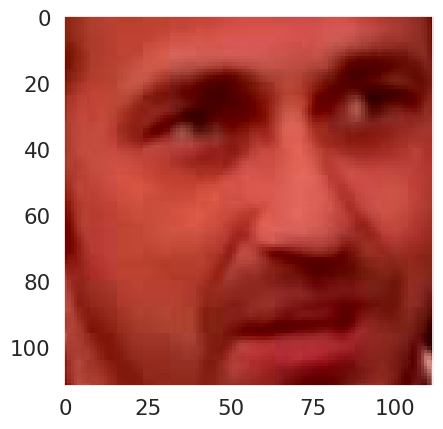

In [ ]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/Data/Gobal_metadata.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

In [ ]:
# from torchinfo import summary
# from torch import nn
# from torchvision import models

# model = models.efficientnet_b1(weights="IMAGENET1K_V1")
# for param in model.features.parameters():
#     param.requires_grad = False
# model.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(in_features=1280,
#                     out_features=2, # same number of output units as our number of classes
#                     bias=True)).to(device)

# summary(model, input_size=((4,3,112,112)), col_names=["input_size", "output_size", "num_params", "trainable"],)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 59.5MB/s]


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [4, 3, 112, 112]          [4, 2]                    --                        Partial
├─Sequential: 1-1                                       [4, 3, 112, 112]          [4, 1280, 4, 4]           --                        False
│    └─Conv2dNormActivation: 2-1                        [4, 3, 112, 112]          [4, 32, 56, 56]           --                        False
│    │    └─Conv2d: 3-1                                 [4, 3, 112, 112]          [4, 32, 56, 56]           (864)                     False
│    │    └─BatchNorm2d: 3-2                            [4, 32, 56, 56]           [4, 32, 56, 56]           (64)                      False
│    │    └─SiLU: 3-3                                   [4, 32, 56, 56]           [4, 32, 56, 56]           --                        --
│    └─Sequential

In [ ]:
# #Model with feature visualization
# from torch import nn
# from torchvision import models
# class Model(nn.Module):
#     def __init__(self, num_classes,latent_dim= 25088, lstm_layers=1 , hidden_dim = 25088, bidirectional = False):
#         super(Model, self).__init__()
#         # model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN


#         # VGG16

#         model = models.efficientnet_b1(weights="IMAGENET1K_V1")
#         for param in model.features.parameters():
#           param.requires_grad = False

#         self.model = nn.Sequential(*list(model.children())[:-2])
#         self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
#         self.relu = nn.LeakyReLU()
#         self.dp = nn.Dropout(0.4)
#         self.linear1 = nn.Linear(25088,num_classes)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
#     def forward(self, x):
#         batch_size,seq_length, c, h, w = x.shape
#         x = x.view(batch_size * seq_length, c, h, w)
#         fmap = self.model(x)
#         x = self.avgpool(fmap)
#         x = x.view(batch_size,seq_length,25088)
#         x_lstm,_ = self.lstm(x,None)
#         return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
# from torch import nn
# from torchvision import models
# class Model(nn.Module):
#     def __init__(self, num_classes,latent_dim= 1792, lstm_layers=1 , hidden_dim = 1792, bidirectional = False):
#         super(Model, self).__init__()
#         # model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
#         # wts =
#         # model = models.resnext50_32x4d(wts) #Residual Network CNN
#         # weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
#         # model = models.efficientnet_b0(weights)



#         # VGG16

#         # model = models.vgg16(weights="IMAGENET1K_V1")
#         # for param in model.features.parameters():
#         #   param.requires_grad = False

#         # EffNet B4
#         wts = torchvision.models.EfficientNet_B4_Weights.IMAGENET1K_V1
#         model = models.efficientnet_b4(weights=wts)

#         # Code for frezzing layers
#         # for param in model.features.parameters():
#         #   param.requires_grad = False

#         self.model = nn.Sequential(*list(model.children())[:-2])
#         self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
#         self.relu = nn.LeakyReLU()
#         self.dp = nn.Dropout(0.4)
#         self.linear1 = nn.Linear(1792,num_classes)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
#     def forward(self, x):
#         batch_size,seq_length, c, h, w = x.shape
#         x = x.view(batch_size * seq_length, c, h, w)
#         fmap = self.model(x)
#         x = self.avgpool(fmap)
#         x = x.view(batch_size,seq_length,1792)
#         x_lstm,_ = self.lstm(x,None)
#         return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))


In [ ]:
# from torch import nn
# from torchvision import models
# class Model(nn.Module):
#     def __init__(self, num_classes,latent_dim= 1280, lstm_layers=1 , hidden_dim = 1280, bidirectional = False):
#         super(Model, self).__init__()
#         # model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
#         # wts =
#         # model = models.resnext50_32x4d(wts) #Residual Network CNN
#         # weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
#         # model = models.efficientnet_b0(weights)



#         # VGG16

#         # model = models.vgg16(weights="IMAGENET1K_V1")
#         # for param in model.features.parameters():
#         #   param.requires_grad = False

#         # EffNet B1
#         wts = torchvision.models.EfficientNet_B1_Weights.IMAGENET1K_V1
#         model = models.efficientnet_b1(weights=wts)

#         # Code for frezzing layers
#         # for param in model.features.parameters():
#         #   param.requires_grad = False

#         self.model = nn.Sequential(*list(model.children())[:-2])
#         self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
#         self.relu = nn.LeakyReLU()
#         self.dp = nn.Dropout(0.4)
#         self.linear1 = nn.Linear(1280,num_classes)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
#     def forward(self, x):
#         batch_size,seq_length, c, h, w = x.shape
#         x = x.view(batch_size * seq_length, c, h, w)
#         fmap = self.model(x)
#         x = self.avgpool(fmap)
#         x = x.view(batch_size,seq_length,1280)
#         x_lstm,_ = self.lstm(x,None)
#         return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))


In [ ]:
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 1536, lstm_layers=1 , hidden_dim = 1536, bidirectional = False):
        super(Model, self).__init__()
        # model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        # wts =
        # model = models.resnext50_32x4d(wts) #Residual Network CNN
        # weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
        # model = models.efficientnet_b0(weights)



        # VGG16

        # model = models.vgg11(weights="IMAGENET1K_V1")
        # for param in model.features.parameters():
        #   param.requires_grad = False

        # EffNet B4
        wts = torchvision.models.EfficientNet_B3_Weights.IMAGENET1K_V1
        model = models.efficientnet_b3(weights=wts)

        # Code for frezzing layers
        # for param in model.features.parameters():
        #   param.requires_grad = False

        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(1536,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,1536)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))


In [ ]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

In [ ]:
summary(model, input_size=((1,20,3,112,112)), col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
Model                                                        [1, 20, 3, 112, 112]      [20, 1536, 4, 4]          --                        True
├─Sequential: 1-1                                            [20, 3, 112, 112]         [20, 1536, 4, 4]          --                        True
│    └─Sequential: 2-1                                       [20, 3, 112, 112]         [20, 1536, 4, 4]          --                        True
│    │    └─Conv2dNormActivation: 3-1                        [20, 3, 112, 112]         [20, 40, 56, 56]          1,160                     True
│    │    └─Sequential: 3-2                                  [20, 40, 56, 56]          [20, 24, 56, 56]          3,504                     True
│    │    └─Sequential: 3-3                                  [20, 24, 56, 56]          [20, 32, 28, 28]          48,118            

Dont run

In [ ]:
# Effnet b0  summary - dont run
summary(model, input_size=((1,20,3,112,112)), col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
Model                                                        [1, 20, 3, 112, 112]      [20, 1280, 4, 4]          --                        True
├─Sequential: 1-1                                            [20, 3, 112, 112]         [20, 1280, 4, 4]          --                        True
│    └─Sequential: 2-1                                       [20, 3, 112, 112]         [20, 1280, 4, 4]          --                        True
│    │    └─Conv2dNormActivation: 3-1                        [20, 3, 112, 112]         [20, 32, 56, 56]          928                       True
│    │    └─Sequential: 3-2                                  [20, 32, 56, 56]          [20, 16, 56, 56]          1,448                     True
│    │    └─Sequential: 3-3                                  [20, 16, 56, 56]          [20, 24, 28, 28]          16,714            

In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):

    model.train()
    # print('Training')
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []

    # Chg for training results
    # true=[]
    # pred=[]

    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))

        # # Chg for training results
        # _,p = torch.max(outputs,1)
        # true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
        # pred += p.detach().cpu().numpy().reshape(len(p)).tolist()

        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    # print(' - Training Accuracy - {}%'.format(round(accuracies.avg,4)))
    print('\t- Training')
    # Chg for training results
    return losses.avg,accuracies.avg
    # return true,pred,losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    # print('Validation -')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        # print('\t- Validation Accuracy - {}%'.format(round(accuracies.avg,4)))
        print('\t- Validation')
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Accuracy",calculated_acc*100)
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size

    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt="d") # font size
    # fmt=".2%"
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()



# def print_confusion_matrix_train(y_true, y_pred):
#     # print('Training results')
#     cm = confusion_matrix(y_true, y_pred)
#     print('True positive = ', cm[0][0])
#     print('False positive = ', cm[0][1])
#     print('False negative = ', cm[1][0])
#     print('True negative = ', cm[1][1])
#     print('\n')
#     calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
#     print("Overall Training Accuracy",calculated_acc*100)

#     df_cm = pd.DataFrame(cm, range(2), range(2))
#     sn.set(font_scale=1.4) # for label size

#     sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt="d") # font size
#     # fmt=".2%"
#     plt.ylabel('Actual label', size = 20)
#     plt.xlabel('Predicted label', size = 20)
#     plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
#     plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
#     plt.ylim([2, 0])
#     plt.show()
#     print('------------------------------------')


In [ ]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  # print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 233 / 234] [Loss: 0.691067, Acc: 54.28%]	- Training
[Batch 58 / 59]  [Loss: 0.690971, Acc: 53.85%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.689153, Acc: 53.75%]	- Training
[Batch 58 / 59]  [Loss: 0.685727, Acc: 57.69%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.684653, Acc: 59.74%]	- Training
[Batch 58 / 59]  [Loss: 0.678253, Acc: 66.67%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.662141, Acc: 67.99%]	- Training
[Batch 58 / 59]  [Loss: 0.657812, Acc: 65.38%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.623584, Acc: 72.06%]	- Training
[Batch 58 / 59]  [Loss: 0.606177, Acc: 69.66%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.568256, Acc: 74.41%]	- Training
[Batch 58 / 59]  [Loss: 0.569975, Acc: 68.80%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.510865, Acc: 79.12%]	- Training
[Batch 58 / 59]  [Loss: 0.510363, Acc: 73.93%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.491452, Acc: 81.16%]	- Training
[Bat

Effb2 results

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 233 / 234] [Loss: 0.691700, Acc: 51.93%]	- Training
[Batch 58 / 59]  [Loss: 0.691447, Acc: 50.00%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.688344, Acc: 56.00%]	- Training
[Batch 58 / 59]  [Loss: 0.677821, Acc: 64.96%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.664075, Acc: 66.06%]	- Training
[Batch 58 / 59]  [Loss: 0.641203, Acc: 68.38%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.606020, Acc: 74.09%]	- Training
[Batch 58 / 59]  [Loss: 0.574386, Acc: 70.94%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.513773, Acc: 78.80%]	- Training
[Batch 58 / 59]  [Loss: 0.505740, Acc: 73.50%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.506598, Acc: 78.05%]	- Training
[Batch 58 / 59]  [Loss: 0.467322, Acc: 77.35%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.463471, Acc: 80.62%]	- Training
[Batch 58 / 59]  [Loss: 0.441670, Acc: 76.92%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.435467, Acc: 83.19%]	- Training
[Bat

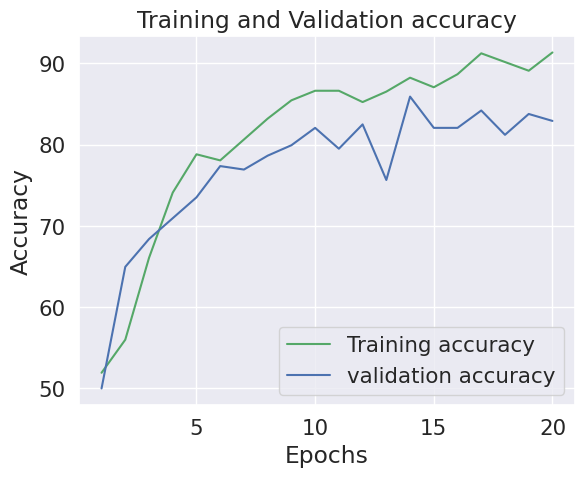

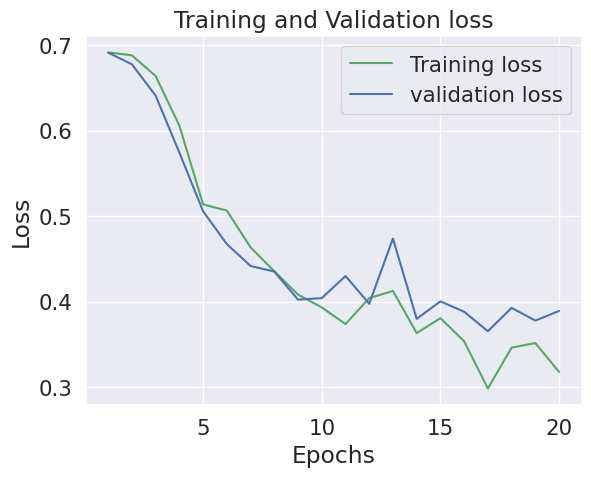

Confusion matrix
[[ 86  24]
 [ 16 108]]
True positive =  86
False positive =  24
False negative =  16
True negative =  108


Accuracy 82.90598290598291


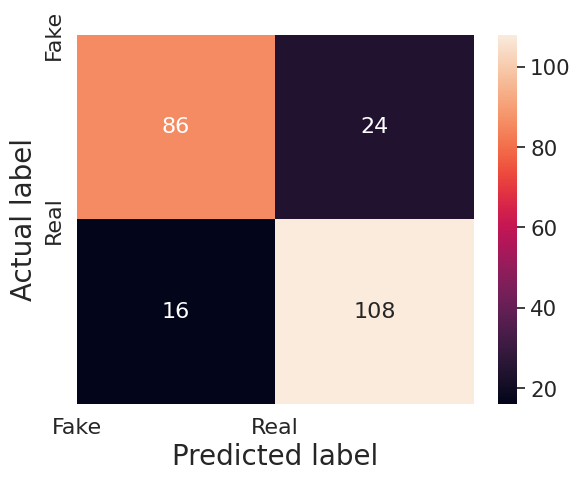

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

effB4 20 epochs

[Epoch 1/20] [Batch 233 / 234] [Loss: 0.693362, Acc: 48.82%]	- Training
[Batch 58 / 59]  [Loss: 0.692545, Acc: 49.57%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.692403, Acc: 53.10%]	- Training
[Batch 58 / 59]  [Loss: 0.692344, Acc: 52.99%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.690211, Acc: 53.53%]	- Training
[Batch 58 / 59]  [Loss: 0.690623, Acc: 52.56%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.689125, Acc: 53.64%]	- Training
[Batch 58 / 59]  [Loss: 0.688820, Acc: 56.41%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.683873, Acc: 62.42%]	- Training
[Batch 58 / 59]  [Loss: 0.687642, Acc: 55.13%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.682715, Acc: 57.39%]	- Training
[Batch 58 / 59]  [Loss: 0.684180, Acc: 57.69%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.677898, Acc: 61.24%]	- Training
[Batch 58 / 59]  [Loss: 0.679593, Acc: 61.11%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.671915, Acc: 61.24%]	- Training
[Bat

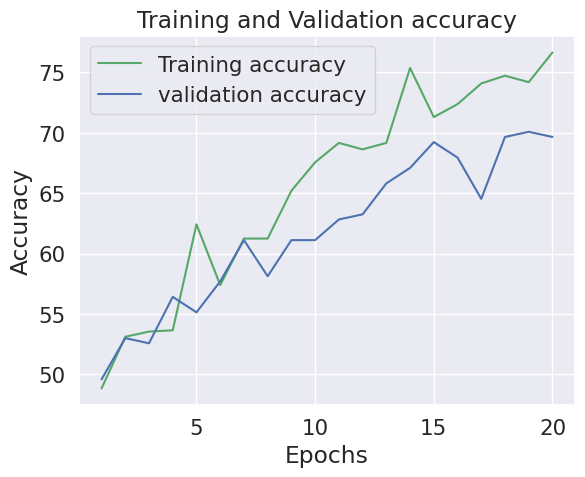

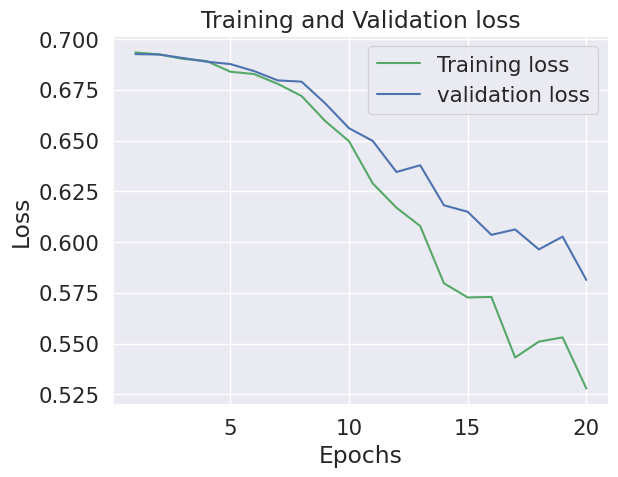

Confusion matrix
[[88 22]
 [49 75]]
True positive =  88
False positive =  22
False negative =  49
True negative =  75


Accuracy 69.65811965811966


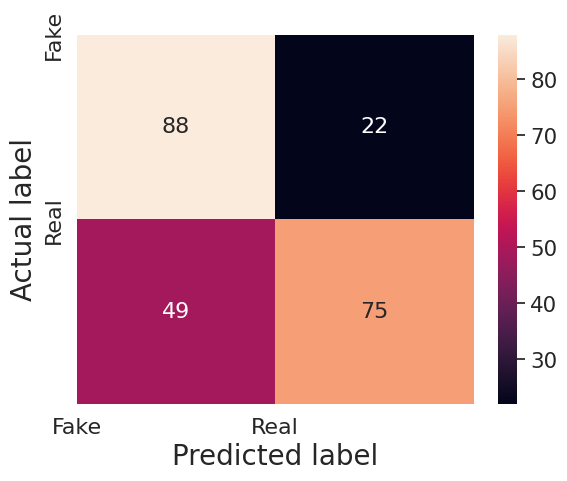

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

Extra 20 for  EffB4

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 233 / 234] [Loss: 0.511563, Acc: 77.84%]	- Training
[Batch 58 / 59]  [Loss: 0.596408, Acc: 70.94%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.530150, Acc: 77.19%]	- Training
[Batch 58 / 59]  [Loss: 0.582025, Acc: 71.37%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.526499, Acc: 78.27%]	- Training
[Batch 58 / 59]  [Loss: 0.588627, Acc: 70.09%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.503248, Acc: 79.44%]	- Training
[Batch 58 / 59]  [Loss: 0.596180, Acc: 70.09%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.494377, Acc: 78.69%]	- Training
[Batch 58 / 59]  [Loss: 0.563810, Acc: 70.94%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.494914, Acc: 79.55%]	- Training
[Batch 58 / 59]  [Loss: 0.598395, Acc: 69.66%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.491439, Acc: 79.44%]	- Training
[Batch 58 / 59]  [Loss: 0.552662, Acc: 70.09%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.474020, Acc: 80.62%]	- Training
[Bat

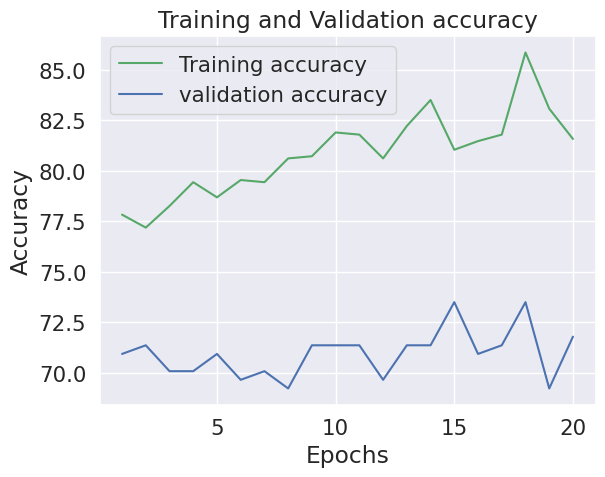

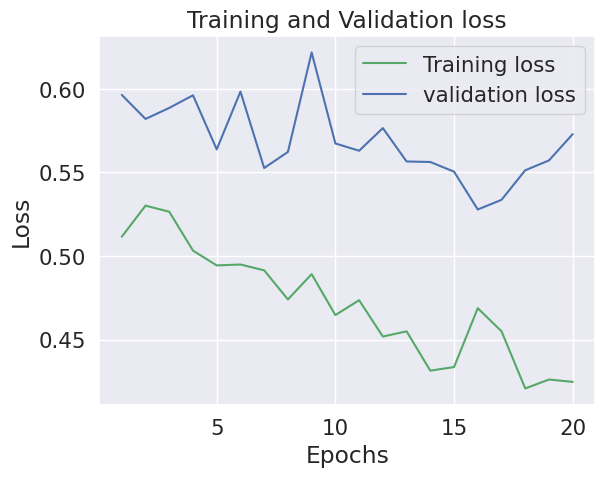

Confusion matrix
[[96 14]
 [52 72]]
True positive =  96
False positive =  14
False negative =  52
True negative =  72


Accuracy 71.7948717948718


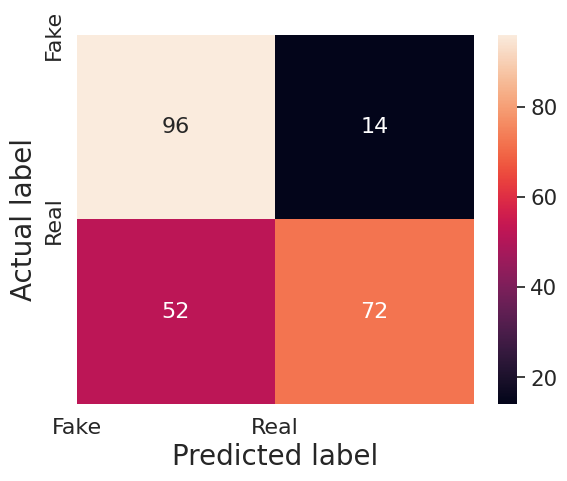

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

To show EffB1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 233 / 234] [Loss: 0.692428, Acc: 50.86%]	- Training
[Batch 58 / 59]  [Loss: 0.685482, Acc: 60.68%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.683575, Acc: 57.28%]	- Training
[Batch 58 / 59]  [Loss: 0.667829, Acc: 68.38%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.665635, Acc: 64.99%]	- Training
[Batch 58 / 59]  [Loss: 0.640433, Acc: 72.22%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.626968, Acc: 70.99%]	- Training
[Batch 58 / 59]  [Loss: 0.575399, Acc: 76.50%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.579812, Acc: 72.27%]	- Training
[Batch 58 / 59]  [Loss: 0.519847, Acc: 78.63%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.540398, Acc: 76.98%]	- Training
[Batch 58 / 59]  [Loss: 0.460533, Acc: 83.76%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.510565, Acc: 79.66%]	- Training
[Batch 58 / 59]  [Loss: 0.421797, Acc: 85.04%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.483846, Acc: 81.05%]	- Training
[Bat

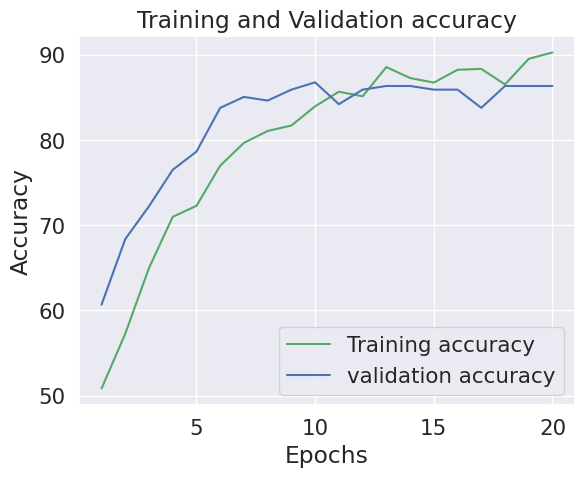

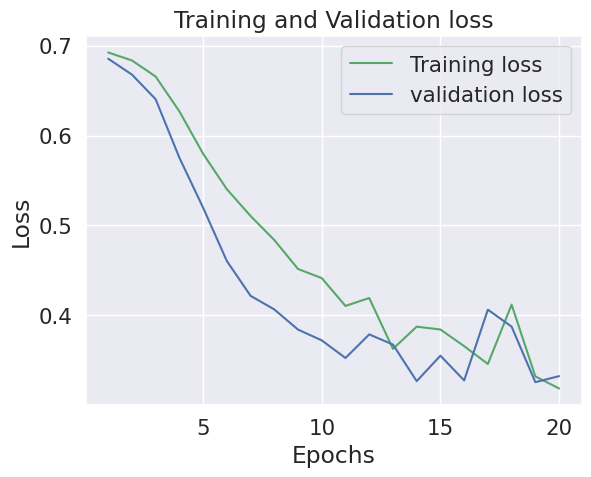

Confusion matrix
[[113  11]
 [ 21  89]]
True positive =  113
False positive =  11
False negative =  21
True negative =  89


Accuracy 86.32478632478633


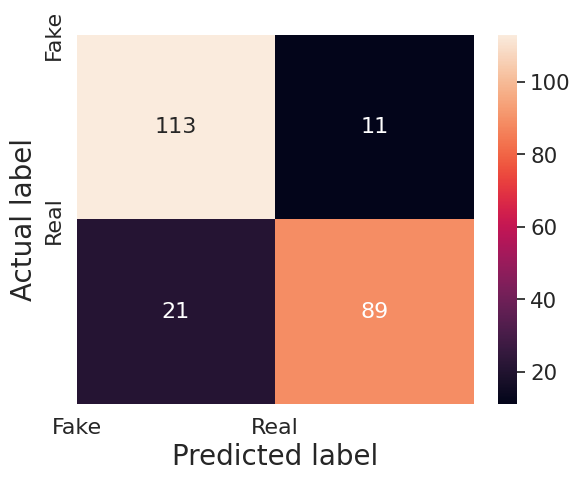

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

Frozen layer EffB1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 233 / 234] [Loss: 0.694924, Acc: 50.96%]	- Training
[Batch 58 / 59]  [Loss: 0.689966, Acc: 59.40%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.690088, Acc: 52.78%]	- Training
[Batch 58 / 59]  [Loss: 0.685970, Acc: 62.82%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.691351, Acc: 55.57%]	- Training
[Batch 58 / 59]  [Loss: 0.679685, Acc: 71.37%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.685035, Acc: 57.28%]	- Training
[Batch 58 / 59]  [Loss: 0.675454, Acc: 71.37%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.677395, Acc: 61.13%]	- Training
[Batch 58 / 59]  [Loss: 0.669881, Acc: 67.09%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.675896, Acc: 60.49%]	- Training
[Batch 58 / 59]  [Loss: 0.661910, Acc: 73.50%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.668736, Acc: 63.38%]	- Training
[Batch 58 / 59]  [Loss: 0.660708, Acc: 73.50%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.667056, Acc: 64.45%]	- Training
[Bat

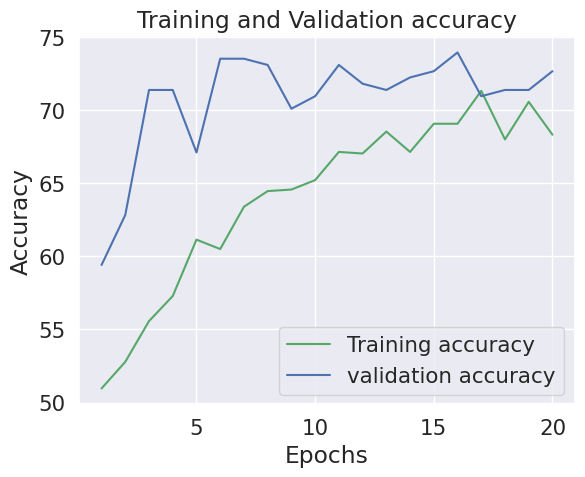

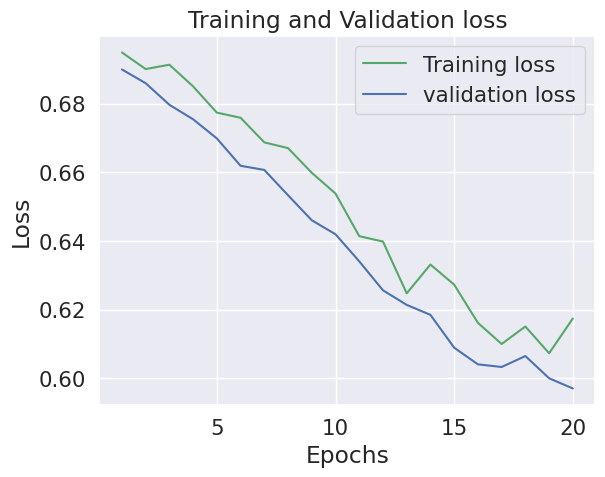

Confusion matrix
[[95 29]
 [35 75]]
True positive =  95
False positive =  29
False negative =  35
True negative =  75


Accuracy 72.64957264957265


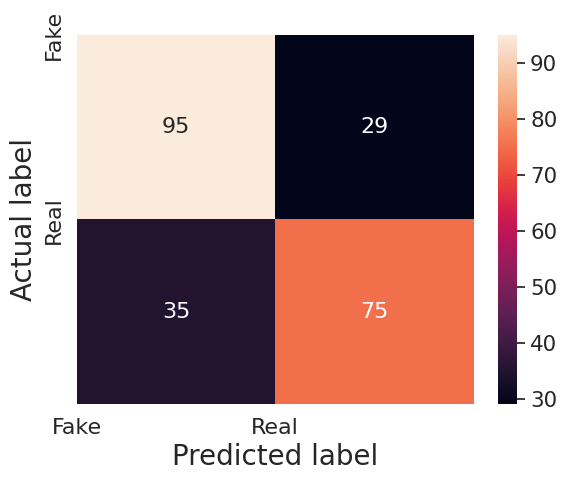

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

one result eff1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 233 / 234] [Loss: 0.690973, Acc: 53.00%]	- Training
[Batch 58 / 59]  [Loss: 0.689209, Acc: 49.57%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.687373, Acc: 57.49%]	- Training
[Batch 58 / 59]  [Loss: 0.675889, Acc: 68.80%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.667536, Acc: 64.35%]	- Training
[Batch 58 / 59]  [Loss: 0.657969, Acc: 62.82%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.639952, Acc: 67.77%]	- Training
[Batch 58 / 59]  [Loss: 0.597322, Acc: 73.50%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.585658, Acc: 73.55%]	- Training
[Batch 58 / 59]  [Loss: 0.523002, Acc: 80.34%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.527806, Acc: 79.87%]	- Training
[Batch 58 / 59]  [Loss: 0.464871, Acc: 80.77%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.483890, Acc: 79.98%]	- Training
[Batch 58 / 59]  [Loss: 0.423457, Acc: 82.91%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.480138, Acc: 81.26%]	- Training
[Bat

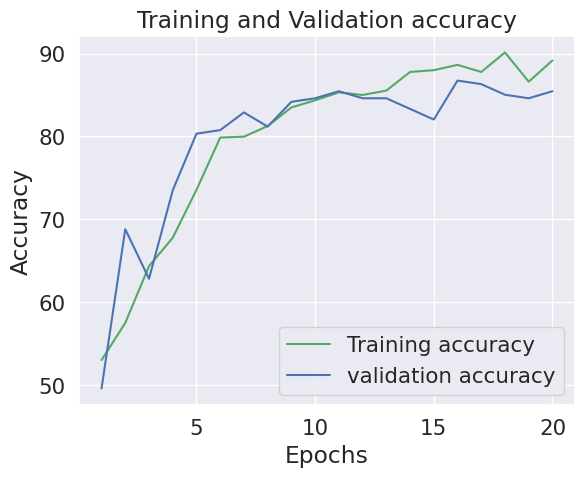

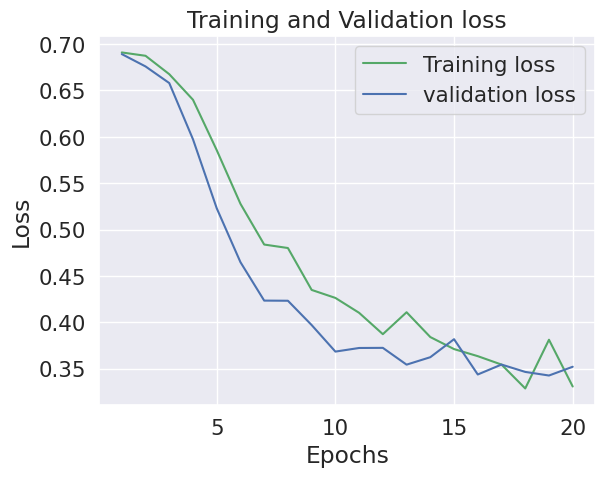

Confusion matrix
[[111  13]
 [ 21  89]]
True positive =  111
False positive =  13
False negative =  21
True negative =  89


Accuracy 85.47008547008546


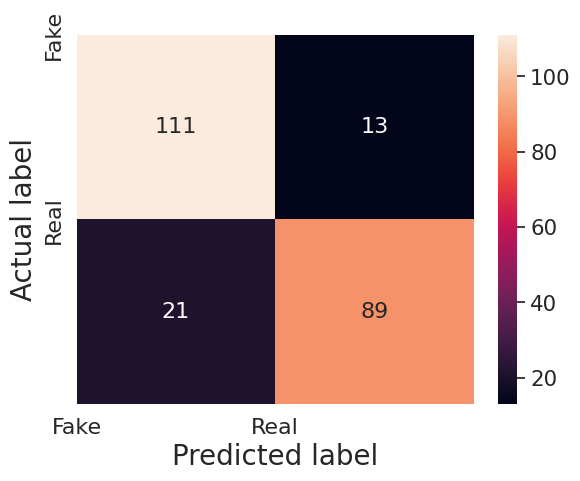

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

To show for effnet b0

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 233 / 234] [Loss: 0.689552, Acc: 54.07%]	- Training
[Batch 58 / 59]  [Loss: 0.683671, Acc: 52.14%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.680244, Acc: 62.96%]	- Training
[Batch 58 / 59]  [Loss: 0.654835, Acc: 73.93%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.643807, Acc: 68.63%]	- Training
[Batch 58 / 59]  [Loss: 0.586422, Acc: 81.62%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.606947, Acc: 70.24%]	- Training
[Batch 58 / 59]  [Loss: 0.517102, Acc: 79.49%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.535083, Acc: 77.73%]	- Training
[Batch 58 / 59]  [Loss: 0.458566, Acc: 81.20%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.519425, Acc: 78.37%]	- Training
[Batch 58 / 59]  [Loss: 0.438124, Acc: 79.91%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.470184, Acc: 82.23%]	- Training
[Batch 58 / 59]  [Loss: 0.406540, Acc: 82.48%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.456204, Acc: 81.80%]	- Training
[Bat

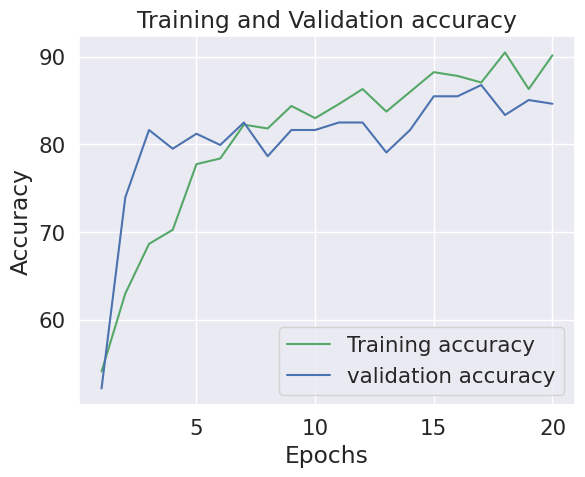

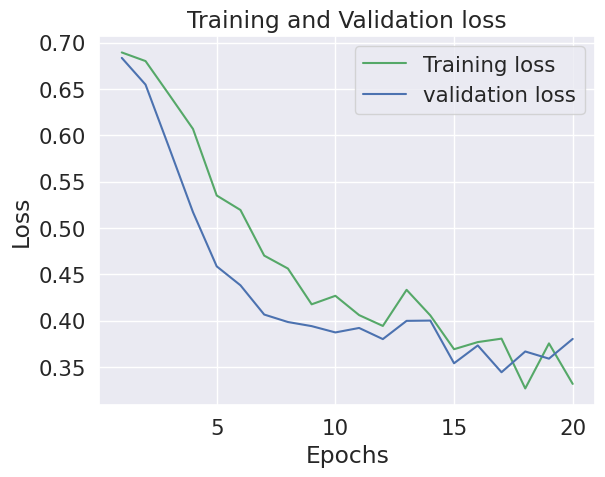

Confusion matrix
[[105  10]
 [ 26  93]]
True positive =  105
False positive =  10
False negative =  26
True negative =  93


Accuracy 84.61538461538461


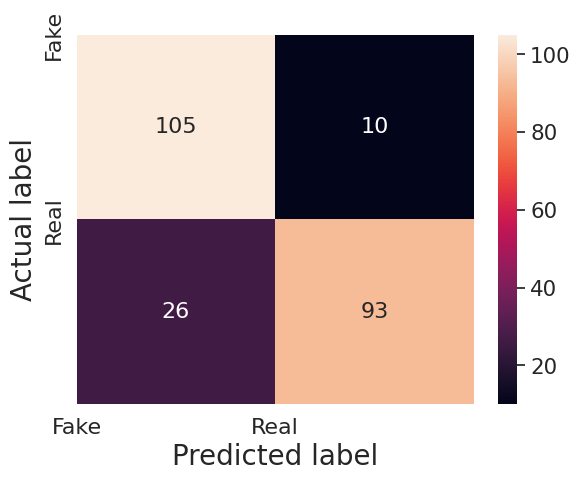

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

frozen layer for effnet b0

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/20] [Batch 233 / 234] [Loss: 0.692575, Acc: 50.00%]	- Training
[Batch 58 / 59]  [Loss: 0.689304, Acc: 55.56%]	- Validation
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.687252, Acc: 56.42%]	- Training
[Batch 58 / 59]  [Loss: 0.680751, Acc: 60.68%]	- Validation
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.682586, Acc: 61.03%]	- Training
[Batch 58 / 59]  [Loss: 0.676573, Acc: 65.38%]	- Validation
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.675832, Acc: 61.13%]	- Training
[Batch 58 / 59]  [Loss: 0.668629, Acc: 61.97%]	- Validation
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.669498, Acc: 63.06%]	- Training
[Batch 58 / 59]  [Loss: 0.660589, Acc: 71.79%]	- Validation
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.663063, Acc: 63.28%]	- Training
[Batch 58 / 59]  [Loss: 0.656053, Acc: 66.67%]	- Validation
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.653702, Acc: 67.13%]	- Training
[Batch 58 / 59]  [Loss: 0.647689, Acc: 69.66%]	- Validation
[Epoch 8/20] [Batch 233 / 234] [Loss: 0.651400, Acc: 67.24%]	- Training
[Bat

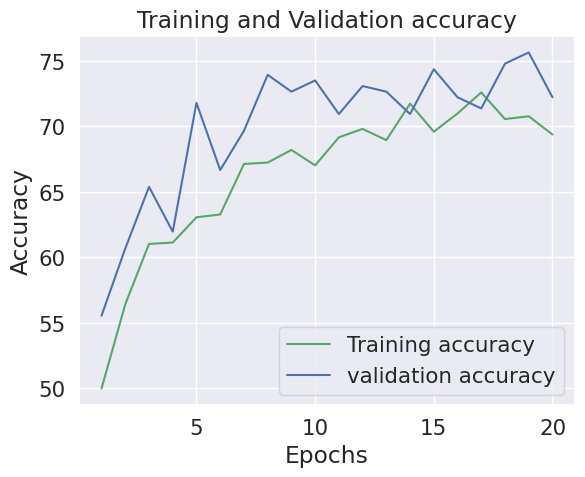

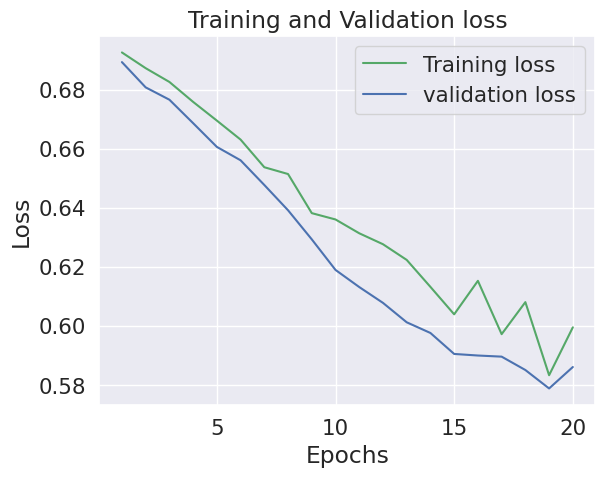

Confusion matrix
[[81 34]
 [31 88]]
True positive =  81
False positive =  34
False negative =  31
True negative =  88


Accuracy 72.22222222222221


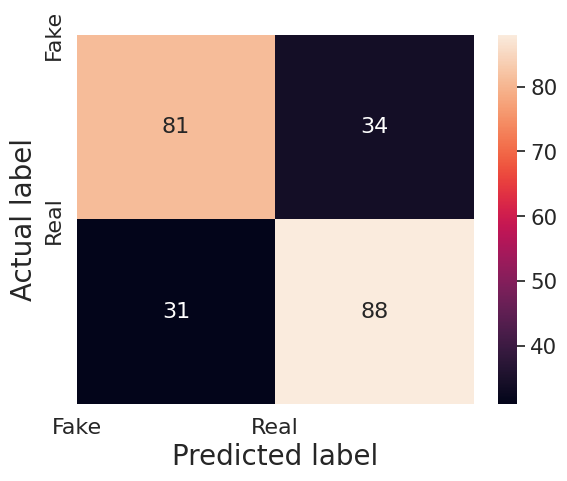

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))


# # print_confusion_matrix_train
# print("Training confusion matrix")
# print(confusion_matrix(train_true,train_pred))
# print_confusion_matrix_train(train_true,train_pred)

print("Confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

Extra res w/o frozen

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 1/10] [Batch 233 / 234] [Loss: 0.363391, Acc: 88.76%]Testing
[Batch 58 / 59]  [Loss: 0.389386, Acc: 85.04%]
Accuracy 85.04273504273505
[Epoch 2/10] [Batch 233 / 234] [Loss: 0.331410, Acc: 89.08%]Testing
[Batch 58 / 59]  [Loss: 0.398783, Acc: 83.33%]
Accuracy 83.33333333333333
[Epoch 3/10] [Batch 233 / 234] [Loss: 0.307586, Acc: 91.86%]Testing
[Batch 58 / 59]  [Loss: 0.503883, Acc: 79.06%]
Accuracy 79.05982905982906
[Epoch 4/10] [Batch 233 / 234] [Loss: 0.298439, Acc: 91.43%]Testing
[Batch 58 / 59]  [Loss: 0.437589, Acc: 80.34%]
Accuracy 80.34188034188034
[Epoch 5/10] [Batch 233 / 234] [Loss: 0.329240, Acc: 88.87%]Testing
[Batch 58 / 59]  [Loss: 0.374539, Acc: 83.33%]
Accuracy 83.33333333333333
[Epoch 6/10] [Batch 233 / 234] [Loss: 0.340470, Acc: 89.61%]Testing
[Batch 58 / 59]  [Loss: 0.504265, Acc: 78.63%]
Accuracy 78.63247863247864
[Epoch 7/10] [Batch 233 / 234] [Loss: 0.294926, Acc: 91.76%]Testing
[Batch 58 / 59]  [Loss: 0.468541, Acc: 79.06%]
Accuracy 79.05982905982906
[Epoch

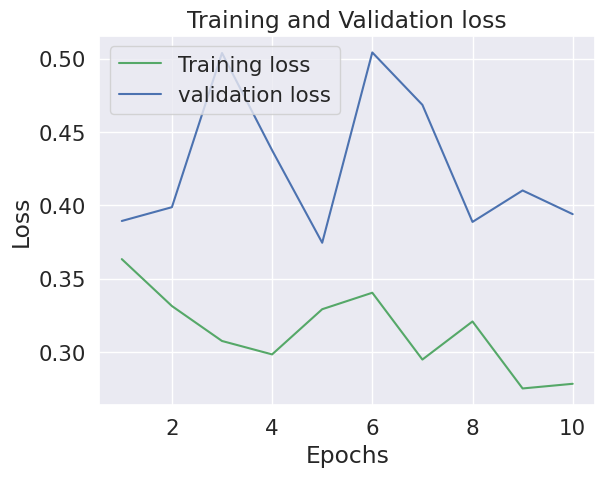

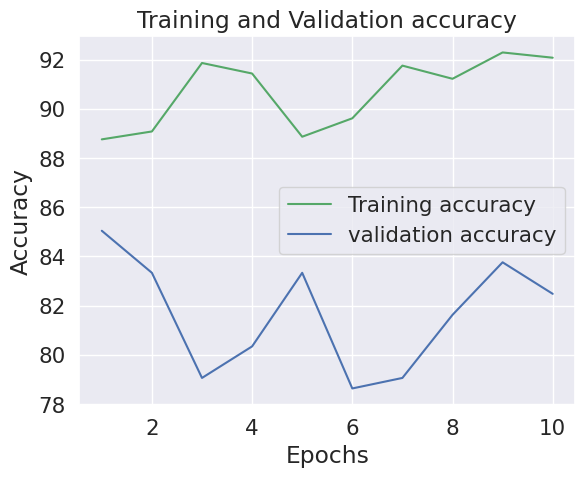

[[95 20]
 [21 98]]
True positive =  95
False positive =  20
False negative =  21
True negative =  98




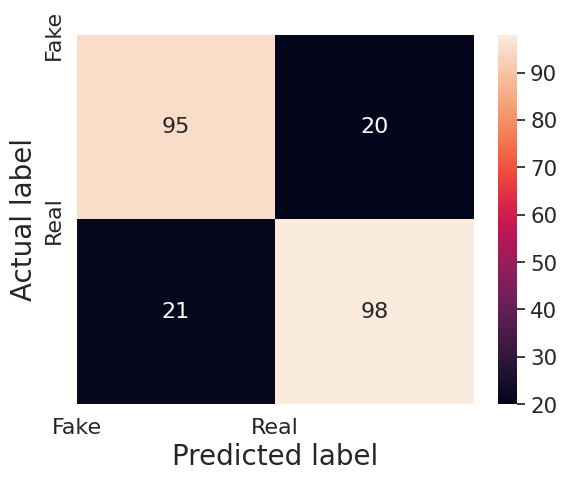

Calculated Accuracy 82.47863247863248


In [ ]:
# 10 more epochs
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

With frozen layers EFF0

[Epoch 1/20] [Batch 233 / 234] [Loss: 0.691932, Acc: 51.18%] - Training Accuracy - 51.1777%
[Batch 58 / 59]  [Loss: 0.684788, Acc: 61.97%]	- Validation Accuracy - 61.9658%
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.687150, Acc: 56.85%] - Training Accuracy - 56.8522%
[Batch 58 / 59]  [Loss: 0.679697, Acc: 65.38%]	- Validation Accuracy - 65.3846%
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.682907, Acc: 58.89%] - Training Accuracy - 58.8865%
[Batch 58 / 59]  [Loss: 0.673109, Acc: 67.95%]	- Validation Accuracy - 67.9487%
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.678906, Acc: 62.10%] - Training Accuracy - 62.0985%
[Batch 58 / 59]  [Loss: 0.667533, Acc: 67.09%]	- Validation Accuracy - 67.094%
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.669277, Acc: 65.31%] - Training Accuracy - 65.3105%
[Batch 58 / 59]  [Loss: 0.663020, Acc: 70.09%]	- Validation Accuracy - 70.0855%
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.667776, Acc: 62.74%] - Training Accuracy - 62.7409%
[Batch 58 / 59]  [Loss: 0.650701, Acc: 68.80%]	- 

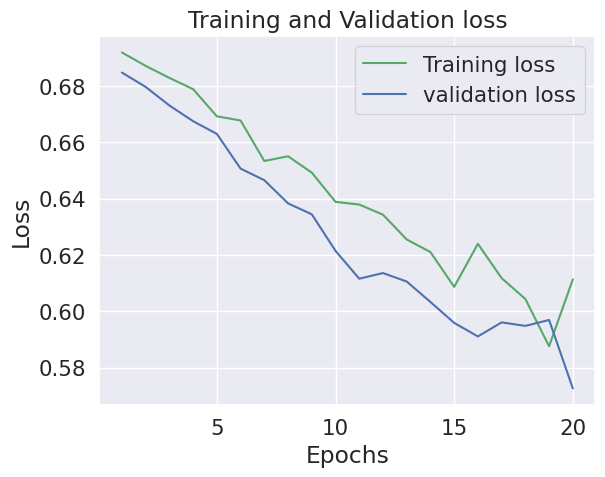

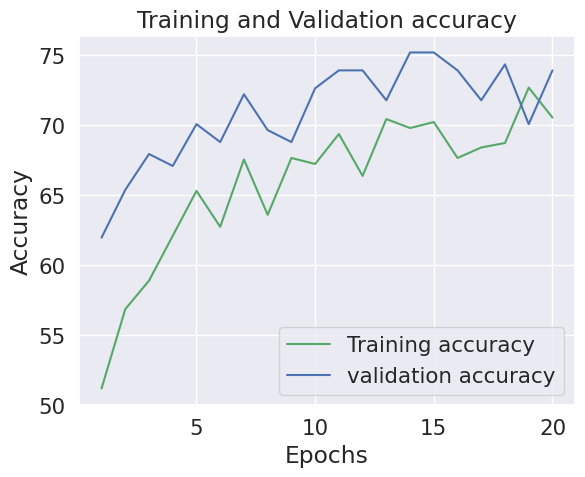

Training confusion matrix
[[356 109]
 [202 267]]
True positive =  356
False positive =  109
False negative =  202
True negative =  267


Overall Training Accuracy 66.70235546038545


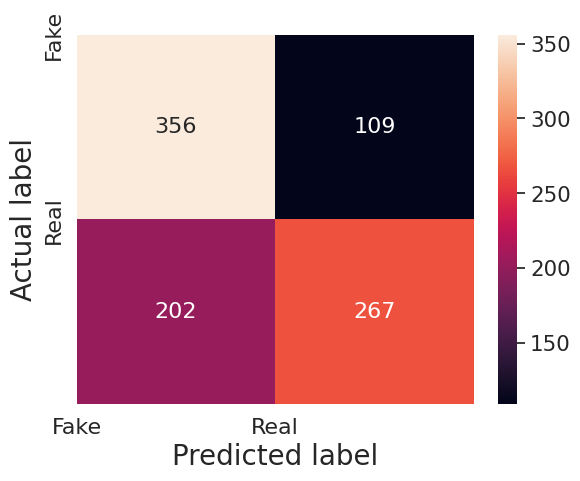

------------------------------------
Testing confusion matrix
[[86 29]
 [32 87]]
True positive =  86
False positive =  29
False negative =  32
True negative =  87


Testing Accuracy 73.93162393162393


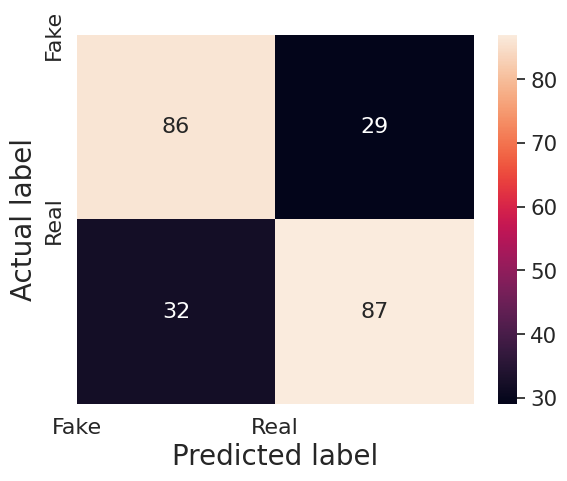

In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    train_true, train_pred,l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

# print_confusion_matrix_train
print("Training confusion matrix")
print(confusion_matrix(train_true,train_pred))
print_confusion_matrix_train(train_true,train_pred)

print("Testing confusion matrix")
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

[Epoch 1/20] [Batch 233 / 234] [Loss: 0.693158, Acc: 50.75%]Testing
[Batch 58 / 59]  [Loss: 0.685461, Acc: 56.41%]
Accuracy 56.41025641025641
[Epoch 2/20] [Batch 233 / 234] [Loss: 0.687480, Acc: 58.14%]Testing
[Batch 58 / 59]  [Loss: 0.677888, Acc: 64.96%]
Accuracy 64.95726495726495
[Epoch 3/20] [Batch 233 / 234] [Loss: 0.679781, Acc: 61.67%]Testing
[Batch 58 / 59]  [Loss: 0.671679, Acc: 64.96%]
Accuracy 64.95726495726495
[Epoch 4/20] [Batch 233 / 234] [Loss: 0.675599, Acc: 63.81%]Testing
[Batch 58 / 59]  [Loss: 0.664730, Acc: 68.38%]
Accuracy 68.37606837606837
[Epoch 5/20] [Batch 233 / 234] [Loss: 0.671625, Acc: 61.78%]Testing
[Batch 58 / 59]  [Loss: 0.660294, Acc: 65.81%]
Accuracy 65.8119658119658
[Epoch 6/20] [Batch 233 / 234] [Loss: 0.658975, Acc: 65.74%]Testing
[Batch 58 / 59]  [Loss: 0.649130, Acc: 70.51%]
Accuracy 70.51282051282051
[Epoch 7/20] [Batch 233 / 234] [Loss: 0.663471, Acc: 65.31%]Testing
[Batch 58 / 59]  [Loss: 0.643011, Acc: 70.51%]
Accuracy 70.51282051282051
[Epoch 

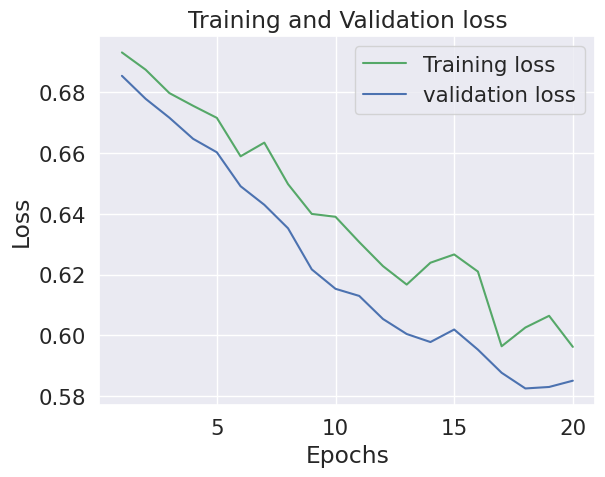

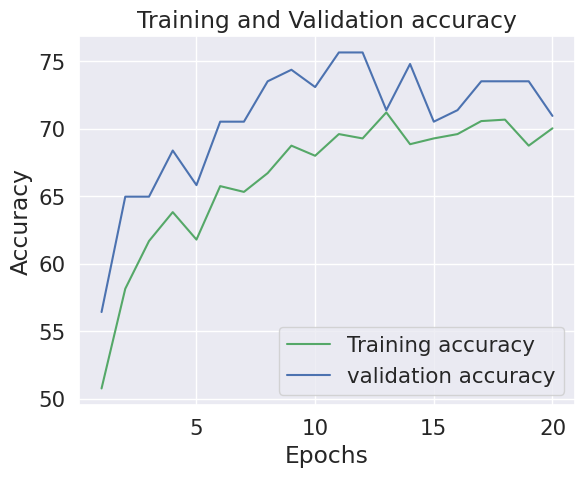

[[70 45]
 [23 96]]
True positive =  70
False positive =  45
False negative =  23
True negative =  96




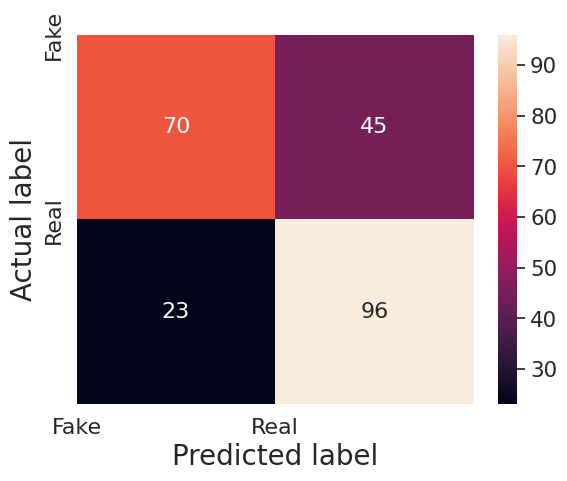

Calculated Accuracy 70.94017094017094


In [ ]:
# Effnet with frozen layer
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)